IMPORTS

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKKMeans


DATA LOADING AND PREPARATION

In [30]:

data = pd.read_csv("Mall_Customers.csv")
data.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Scaled Feature Shape: (200, 4)

Summary Statistics:
            Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.560000   38.850000           60.560000               50.200000
std      0.497633   13.969007           26.264721               25.823522
min      0.000000   18.000000           15.000000                1.000000
25%      0.000000   28.750000           41.500000               34.750000
50%      1.000000   36.000000           61.500000               50.000000
75%      1.000000   49.000000           78.000000               73.000000
max      1.000000   70.000000          137.000000               99.000000


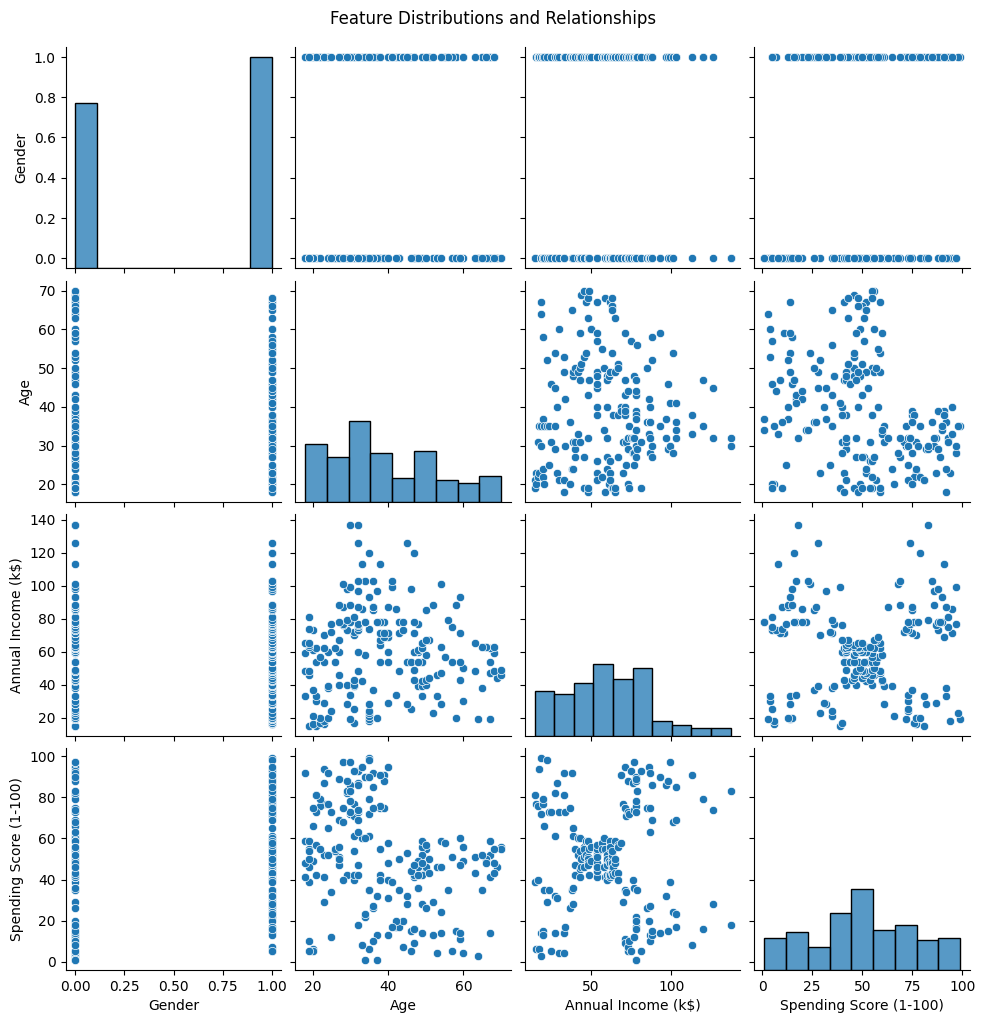

In [31]:

if 'CustomerID' in data.columns:
    data = data.drop('CustomerID', axis=1)

if 'Gender' in data.columns:
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

numeric_features = data.select_dtypes(include=[np.number])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

print("Scaled Feature Shape:", X_scaled.shape)
print("\nSummary Statistics:\n", numeric_features.describe())

# Visualize distributions
sns.pairplot(numeric_features)
plt.suptitle("Feature Distributions and Relationships", y=1.02)
plt.show()


K-means

In [32]:
def initialize_centroids(X, k, random_state=None, kmeans_plus=False):
    np.random.seed(random_state)
    if not kmeans_plus:
        indices = np.random.choice(X.shape[0], k, replace=False)
        return X[indices]

    centroids = []
    centroids.append(X[np.random.randint(0, X.shape[0])])
    for _ in range(1, k):
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2)**2, axis=1)
        probs = distances / distances.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        for i, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[i])
                break
    return np.array(centroids)

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def compute_inertia(X, labels, centroids):
    return np.sum([np.linalg.norm(X[i] - centroids[labels[i]])**2 for i in range(len(X))])

def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, kmeans_plus=False):
    centroids = initialize_centroids(X, k, random_state, kmeans_plus)
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            break
        centroids = new_centroids
    inertia = compute_inertia(X, labels, centroids)
    return centroids, labels, i+1, inertia


CHOOSING CLUSTERS

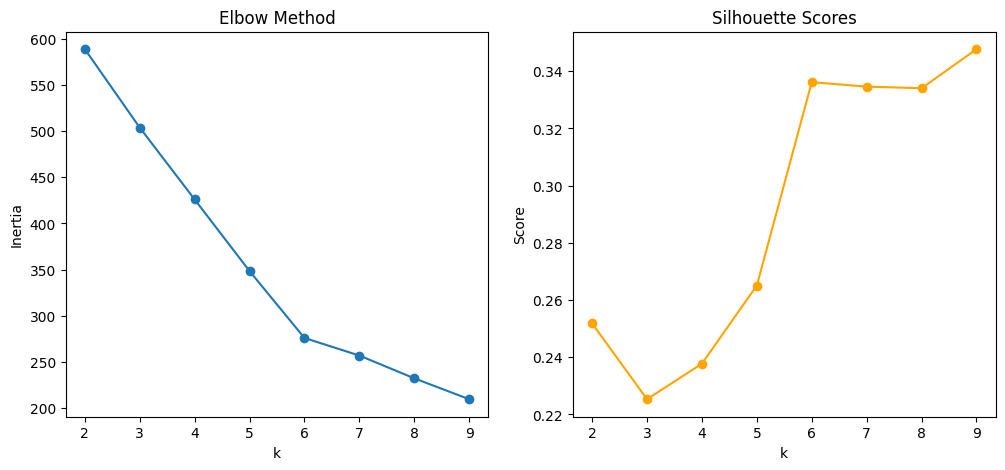

In [33]:
inertias = []
sil_scores = []
K = range(2, 10)

for k in K:
    _, labels, _, inertia = kmeans(X_scaled, k, kmeans_plus=True, random_state=42)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('k'); plt.ylabel('Score')
plt.show()


APPLYING K-MEANS

Converged in 9 iterations | Inertia: 275.81
Final Centroids (Standardized):
 [[-1.12815215  1.31794399 -0.52575662 -0.44589335]
 [ 0.71852548 -0.45870876  1.13802153  1.14232442]
 [ 0.88640526 -0.92608124 -0.70017176  0.28182355]
 [-0.70845269  0.00777472  1.15710625 -1.32446225]
 [-1.12815215 -0.74922584 -0.08890541  0.79653879]
 [ 0.88640526  0.77926664 -0.22892115 -0.51325338]]


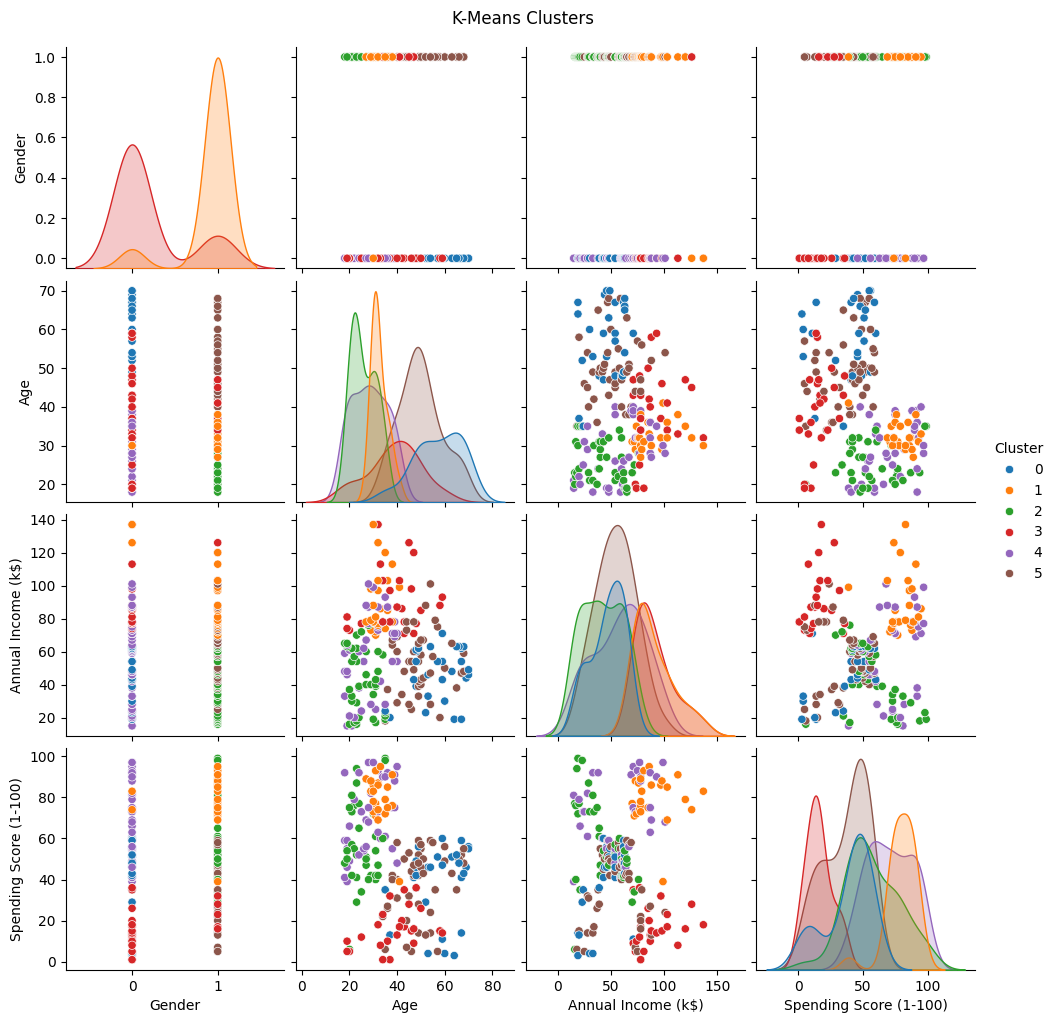

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,0.000000,57.214286,46.785714,38.714286
1,0.916667,32.458333,90.375000,79.625000
2,1.000000,25.945946,42.216216,57.459459
3,0.208333,38.958333,90.875000,16.083333
4,0.000000,28.410256,58.230769,70.717949
5,1.000000,49.708333,54.562500,36.979167


In [36]:
k_opt = 6
centroids, labels, iters, inertia = kmeans(X_scaled, k_opt, random_state=42, kmeans_plus=True)

print(f"Converged in {iters} iterations | Inertia: {inertia:.2f}")
print("Final Centroids (Standardized):\n", centroids)

data['Cluster'] = labels

sns.pairplot(data, hue="Cluster", palette="tab10")
plt.suptitle("K-Means Clusters", y=1.02)
plt.show()

# Cluster statistics
cluster_summary = data.groupby('Cluster').mean()
display(cluster_summary)


SCIKIT-LEARN

Output Inertia: 275.81
sklearn Inertia: 277.39
Iterations: 9, sklearn: 8


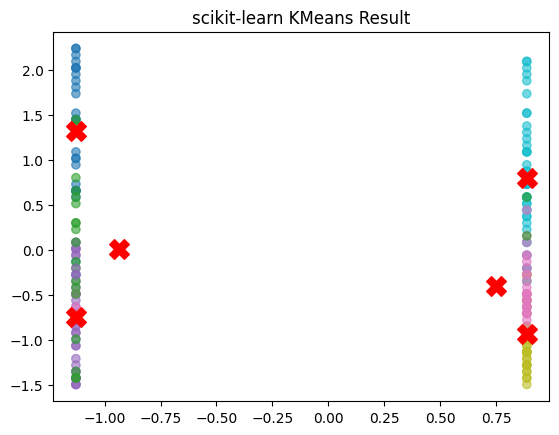

In [38]:
sk_model = SKKMeans(n_clusters=k_opt, random_state=42)
sk_model.fit(X_scaled)

print(f"Output Inertia: {inertia:.2f}")
print(f"sklearn Inertia: {sk_model.inertia_:.2f}")
print(f"Iterations: {iters}, sklearn: {sk_model.n_iter_}")

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=sk_model.labels_, cmap='tab10', alpha=0.6)
plt.scatter(sk_model.cluster_centers_[:, 0], sk_model.cluster_centers_[:, 1], c='red', marker='X', s=200)
plt.title("scikit-learn KMeans Result")
plt.show()
